In [23]:
import pandas as pd
import glob

servers = ["1xCPU", "1xT4",]
servers = ["1xCPU_4G", "1xCPU_20G", "1xT4_4G", "1xT4_20G",]
meas_dir = "/depot/cms/sonic/dkondra/saturation_measurements/"
n_jobs = [1]


columns = servers + ["run_id"]

df = pd.DataFrame(columns=columns)
df.loc[0, :] = [0 for c in columns]
idx = 0
for server in servers:
    for n_job in n_jobs:
        filenames = glob.glob(f"{meas_dir}/{server}/{n_job}jobs_*.txt")
        for filename in filenames:
            run_id = filename.split("_run")[-1].removesuffix(".txt")
            # print(ijob)
            try:
                with open(filename, 'r') as file:
                    values_list = [float(value.strip()) for value in file.readlines()]
                    df.loc[idx, server] = sum(values_list)
                    df.loc[idx, "run_id"] = run_id
                    # df.loc[i, "perfect"] = df.loc[1, server] * i
                    #print(i, values_list)
                    idx += 1
    
            except Exception:
                print(f"Skip {filename}")
# df.loc[200, "1xCPU"] = 2*df.loc[100, "1xCPU"]
df.sort_index(inplace=True)
print(df)

    1xCPU_4G 1xCPU_20G 1xT4_4G  1xT4_20G run_id
0   1.377617         0       0         0     14
1   1.494107       NaN     NaN       NaN      5
2   1.377745       NaN     NaN       NaN     15
3   1.426328       NaN     NaN       NaN      7
4   1.406833       NaN     NaN       NaN      8
..       ...       ...     ...       ...    ...
75       NaN       NaN     NaN  2.398657     19
76       NaN       NaN     NaN  2.410002      1
77       NaN       NaN     NaN  2.404496     13
78       NaN       NaN     NaN  2.416918     12
79       NaN       NaN     NaN  2.402972     11

[80 rows x 5 columns]


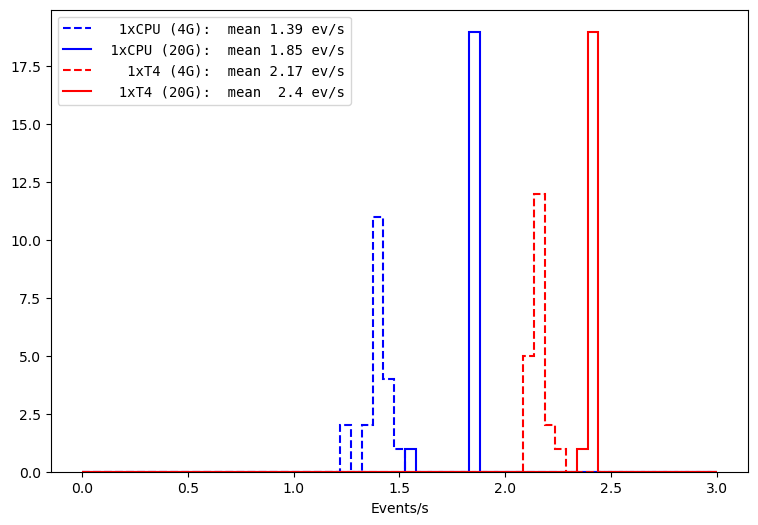

In [21]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

fig, ax = plt.subplots(figsize=(9, 6))

edges = np.linspace(0, 3, 60)
# data = {
#     '1xCPU': df['1xCPU'].dropna(),
#     '1xT4': df.loc[df['1xT4']>0,'1xT4'].dropna()
# }
data = {
    '1xCPU (4G)': df.loc[df['1xCPU_4G']>0,'1xCPU_4G'].dropna(),
    '1xCPU (20G)': df.loc[df['1xCPU_20G']>0,'1xCPU_20G'].dropna(),
    '1xT4 (4G)': df.loc[df['1xT4_4G']>0,'1xT4_4G'].dropna(),
    '1xT4 (20G)': df.loc[df['1xT4_20G']>0,'1xT4_20G'].dropna()
}

means = {k:round(np.mean(v),2) for k,v in data.items()}
std = {k:round(np.std(v),2) for k,v in data.items()}
hists = {k: np.histogram(data[k], bins=edges)[0] for k,v in data.items()}

for k in data.keys():
    label = f'{k:>12}:  mean {means[k]:>4} ev/s'
    # print(hists[k])
    color='blue' if 'CPU' in k else 'red'
    ls = '--' if '4G' in k else '-'
    hep.histplot(hists[k], bins=edges, ax=ax, label=label, color=color, ls=ls)
# hep.histplot(hist_t4, bins=edges, ax=ax, label='1xT4')
# hep.histplot(df['1xT4'].dropna(), bins=edges, ax=ax, label='1xT4', color='orange', alpha=0.7)

ax.set_xlabel('Events/s')
ax.set_ylabel('')
# ax.legend()
ax.legend(prop={'family': 'monospace'})

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = iter(colors)
color_dict = {}
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    gridspec_kw={'height_ratios': [3, 1]},
    figsize=(6, 6)
)

opts1 = {
    "marker": "o",
    "ms": 2,
}
opts2 = {
    "marker": "",
    "ms": 2,
    "linestyle": "--"
}
for server in servers:
    label = server
    if "CPU" in server:
        label = label+" per job"
    color = next(color_cycle)
    color_dict[server] = color
    ax1.plot(df.index, df[server], label=label, color=color, **opts1)

ax1.set_title("SONIC workflow 13_3_X")
# ax1.set_xlabel('Number of parallel jobs')
ax1.set_ylabel('Throughput (ev/s)')
ax1.set_xlim(0, max(n_jobs))
# plt.ylim(0, df.max().max()*1.05)
ax1.set_ylim(0, 300)
# plt.xscale('log')
ax1.legend(title="Triton 21.02-py3-geometric")
ax1.tick_params(axis='x', which='both', labelbottom=True)

div_by_cpu = True
for server in servers:
    if div_by_cpu:
        if "T4" in server:
            color = color_dict[server]
            mask = (df["1xCPU"] != 0)
            ratio = np.divide(df.loc[mask,server], df.loc[mask,"1xCPU"])
            # print(ratio)
            ax2.plot(df[mask].index, ratio, label=f"{server}", color=color, **opts1)
            ax2.set_ylabel('Ratio GPU / CPU-only')
            ax2.set_ylim(0, 2)
    else:
        df_ = df[1:]
        ratio = np.divide(df_[server], df_.index)
        ax2.plot(df[mask].index, ratio, label=f"{server}", **opts1)
        ax2.set_ylabel('Throuphput per job')
        ax2.set_ylim(0, 3)



ax2.set_xlabel('Number of parallel jobs')
ax2.yaxis.grid(True, linestyle='--', alpha=0.8)
# ax2.legend()

plt.tight_layout()
# plt.show()

from datetime import datetime
save_path = "/depot/cms/sonic/dkondra/sonic-studies/plots/"
datestamp = datetime.now().strftime("%d%b%Y")
filename = f"saturation_scan_{datestamp}.pdf"
plt.savefig(save_path+filename)